In [12]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from sympy import * 
import random
import yaml
from scipy.integrate import odeint  

import os, sys
__file__ = 'haptic_graph.ipynb' #__file__ is set to default in scripts but, should declare in notebooks
currentdir = os.path.dirname(os.path.realpath(__file__))
parentdir = os.path.dirname(currentdir)
sys.path.append(parentdir) 

from haptic import haptic_class
from spring_damp import mass_damp_spring

random.seed(49) 



In [ ]:
k = mass_damp_spring(time = 90, increment = 0.01, state = [0,0], force = sin, amplitude= 1,\
    omega = 0.1, no_mass = 5, range_mass= [10, 20], no_spring= 5, range_spring = [1,10], no_damp = 5, range_damp = [0.1, 1])

auto_force = [-1 * i for i in k.force_list] 
human_force = k.force_list

def Diff_theta(Theta, time_array, a, w, ):
    diff_theta = []
    t = Symbol('t')
    y = Theta(t) 
    dt = diff(y, t)
    ddt = lambdify(t, dt)
    for i in time_array:
        diff_theta.append(ddt(i)) 
    return diff_theta 

Diff_H = Diff_theta(sin, k.time_array, k.amplitude, k.omega)
Diff_A = [-1 * i for i in Diff_H]

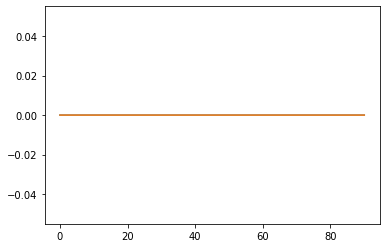

In [13]:
sensor_spring = 1
sw_mass = 5
G = 1
T_v = 0 
J_sm = [1, 1]

def callback_func( state, t): 
    T_h = int(t * 100) 
    dx1dt = state[1] 
    b_h = k.damp[T_h] * (Diff_H[T_h] - state[1]) 
    k_h = k.spring[T_h] * (human_force[T_h] - state[0]) 
    K_t = sensor_spring * (state[0] - state[2]) 
    j1 = sw_mass + k.mass[T_h] 
    dx2dt = (b_h + k_h - K_t) * (1/j1)
    dx3dt = state[3] 
    b_a = G * k.damp[T_h] * (Diff_A[T_h] - (G * state[3]))
    k_a = G * k.spring[T_h] * (auto_force[T_h] - (G * state[2])) 
    dx4dt = (b_a + k_a + K_t + T_v) * ( 1 / ((G **2) * J_sm[1] + J_sm[0]) ) 
    dxdt = [dx1dt, dx2dt, dx3dt, dx4dt] 
    return dxdt 

vector = odeint(callback_func, [0,0,0,0], k.time_array, mxstep = 50000000)
dic = {
    'delta_B_H' : 0,
    'delta_B_A' : 0,
    'delta_K_H' : 0,
    'delta_K_A' : 0
    }

def auto_acc():
    acc_h , acc_a, error = [], [], []
    for i in k.time_array:
        T = int(i * 100)
        b_h = k.damp[T] * (Diff_H[T] - vector[:,1][T] )
        k_h = k.spring[T] * (human_force[T] - vector[:,0][T] ) 
        K_t = sensor_spring * (vector[:,0][T] - vector[:,2][T] ) 
        j1 = sw_mass + k.mass[T]  
        acc_h.append( (b_h + k_h - K_t) * (1/j1) )

        b_a = G * k.damp[T] * (Diff_A[T] - (G * vector[:,3][T] ) )
        k_a = G * k.spring[T] * (auto_force[T] - (G * vector[:,2][T] ) ) 
        deno = ( 1 / ( (G **2) * J_sm[1] + J_sm[0] ) ) 
        num = (b_a + k_a + K_t + T_v) 
        acc_a.append(num * deno) 

        delta_b_h = dic['delta_B_H'] * (Diff_H[T] - vector[:,1][T] )
        delta_k_h = dic['delta_K_H'] * (human_force[T] - vector[:,0][T] ) 
        a = (delta_b_h + delta_k_h) * (1/j1)

        delta_b_a = G * dic['delta_B_A'] * (Diff_A[T] - (G * vector[:,3][T] ) ) 
        delta_k_a = G * dic['delta_K_A'] * (auto_force[T] - (G * vector[:,2][T] ) )
        b = (delta_b_a + delta_k_a) * deno  
        error.append( [a, b] )
    
    return acc_h, acc_a, np.asarray(error) 

_, _, error = auto_acc()

plt.plot(k.time_array, error[:,0])
plt.plot(k.time_array, error[:, 1])

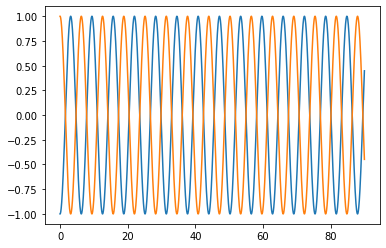

In [18]:
plt.plot(k.time_array, Diff_A)
plt.plot(k.time_array, Diff_H)

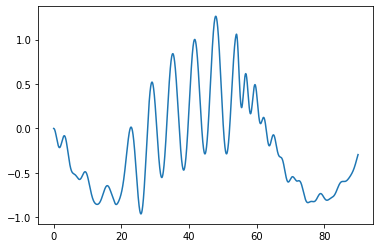

In [17]:

plt.plot(k.time_array, vector[:,2]) 

In [5]:
z = []
for i in range(10):
    z.append([i, i+1])
z = np.asarray(z)
print(z[:,0])
print(z[:, 1])

[0 1 2 3 4 5 6 7 8 9]
[ 1  2  3  4  5  6  7  8  9 10]


In [6]:
a = [1,2,3,4]
b = [-1 * i for i in a]
print(b) 

[-1, -2, -3, -4]


In [4]:
with open('Human_Auto.yaml') as File:
    d = yaml.load(File, Loader=yaml.FullLoader) 
#can't give negative sin as input to function
hap = haptic_class(dic = d, Theta_h = sin, Theta_a= sin) 

Text(0.5, 1.0, 'Human_angular_disp_vel_acc')

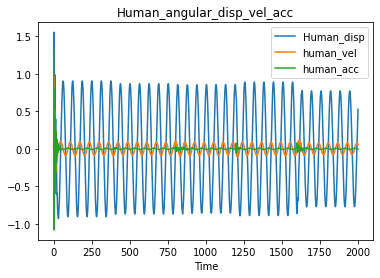

In [9]:
plt.plot(hap.Theta['H_time'], hap._vector[:,0] ) 
plt.plot(hap.Theta['H_time'], hap._vector[:,1] )
plt.plot(hap.Theta['H_time'], hap.acc_sw) 
plt.xlabel('Time')
plt.legend(['Human_disp', 'human_vel', 'human_acc']) 
plt.title('Human_angular_disp_vel_acc') 

Text(0.5, 1.0, 'Auto_angular_disp_vel_acc')

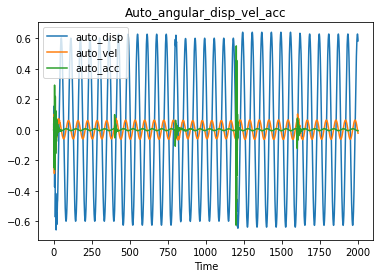

In [10]:
plt.plot(hap.Theta['A_time'],hap._vector[:,2] ) 
plt.plot(hap.Theta['A_time'],hap._vector[:,3] )
plt.plot(hap.Theta['H_time'], hap.acc_s) 
plt.xlabel('Time')
plt.legend(['auto_disp', 'auto_vel', 'auto_acc']) 
plt.title('Auto_angular_disp_vel_acc')

Text(0.5, 1.0, 'ERROR')

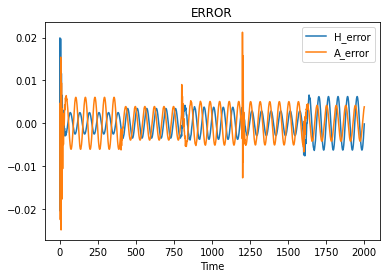

In [11]:
plt.plot(hap.Theta['H_time'],hap.error[:, 0] ) 
plt.plot(hap.Theta['A_time'],hap.error[:,1] )
#plt.plot(hap.Theta['H_time'], hap.acc_a) 
plt.xlabel('Time')
plt.legend(['H_error', 'A_error']) 
plt.title('ERROR')

In [5]:
df = hap.dataframe()

In [6]:
df.to_csv('haptic_sim_1.csv', index=False)  

In [7]:
df = pd.read_csv('haptic_sim_1.csv') 
df

,time_step_H,time_step_A,theta_H,theta_A,H_spring,A_spring,H_damp,A_damp,H_mass,A_mass,disp_sw,disp_s,vel_sw,vel_s,acc_sw,acc_s,error_1,error_2
0,0.00,0.00,10.000000,0.000000,8.842122,4.344843,4.623523,1.251697,1,4,0.000000,0.000000,0.000000,0.000000,14.736871,0.057771,0.833333,0.023077
1,0.01,0.01,9.999995,0.001000,8.842122,4.344843,4.623523,1.251697,1,4,0.000735,0.000003,0.146798,0.000576,14.621767,0.059493,0.830808,0.022891
2,0.02,0.02,9.999980,0.002000,8.842122,4.344843,4.623523,1.251697,1,4,0.002932,0.000012,0.292438,0.001171,14.505143,0.061630,0.828180,0.022699
3,0.03,0.03,9.999955,0.003000,8.842122,4.344843,4.623523,1.251697,1,4,0.006580,0.000026,0.436904,0.001790,14.387031,0.064172,0.825450,0.022498
4,0.04,0.04,9.999920,0.004000,8.842122,4.344843,4.623523,1.251697,1,4,0.011666,0.000048,0.580182,0.002436,14.267461,0.067112,0.822618,0.022288
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8996,89.96,89.96,-9.094745,0.415760,7.679085,3.816761,14.130542,2.362273,4,10,-8.042353,-0.564384,-0.518617,-0.159988,0.094443,0.085283,-0.057323,0.051871
8997,89.97,89.97,-9.098898,0.414850,7.679085,3.816761,14.130542,2.362273,4,10,-8.047535,-0.565979,-0.517656,-0.159127,0.095638,0.085339,-0.057267,0.051584
8998,89.98,89.98,-9.103042,0.413940,7.679085,3.816761,14.130542,2.362273,4,10,-8.052706,-0.567566,-0.516683,-0.158265,0.096815,0.085372,-0.057210,0.051296
8999,89.99,89.99,-9.107177,0.413029,7.679085,3.816761,14.130542,2.362273,4,10,-8.057868,-0.569145,-0.515698,-0.157403,0.097973,0.085381,-0.057154,0.051009


## Error_1

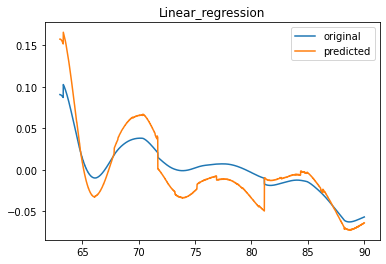

In [10]:
import warnings 
warnings.filterwarnings("ignore") 
import random 
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
lr = LinearRegression()
rfr = RandomForestRegressor(max_depth = 5, n_estimators=100,random_state = 0 )
etr = ExtraTreesRegressor(max_depth = 5, n_estimators = 100, random_state = 0)
gbr = GradientBoostingRegressor(random_state = 0)

df_error_1 = df.iloc[:, :17]  
df_error_2 = df.iloc[:, :16] 
df_error_2['error_2'] = df['error_2'] 

X_train = df_error_1.iloc[:6302, :16]
y_train = df_error_1.iloc[:6302, 16]
X_test = df_error_1.iloc[6302:, :16] 
y_test = df_error_1.iloc[6302:, 16:]

def compare(z1, title): 
    plt.plot(X_test['time_step_H'], y_test['error_1'])
    plt.plot(X_test['time_step_H'], z1)
    plt.legend(['original', 'predicted'])
    plt.title(title) 

lr.fit(X_train, y_train)
z1 = lr.predict(X_test) 
compare(z1, "Linear_regression") 

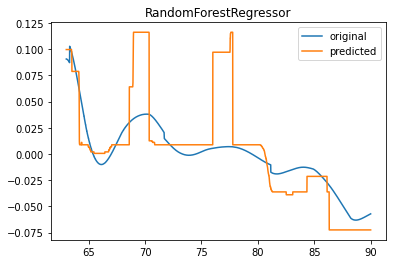

In [11]:
rfr.fit(X_train, y_train) 
z1 = rfr.predict(X_test) 
compare(z1, "RandomForestRegressor") 

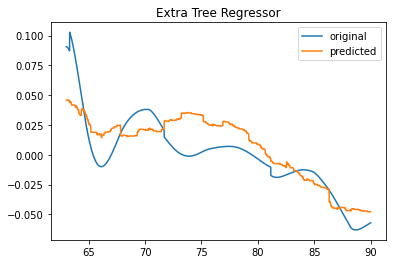

In [12]:
etr.fit(X_train, y_train)
z1 = etr.predict(X_test)  
compare(z1, "Extra Tree Regressor")

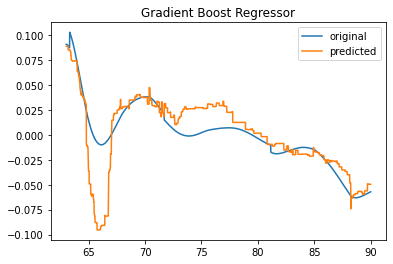

In [13]:
gbr.fit(X_train, y_train) 
z1 = gbr.predict(X_test) 
compare(z1, "Gradient Boost Regressor")

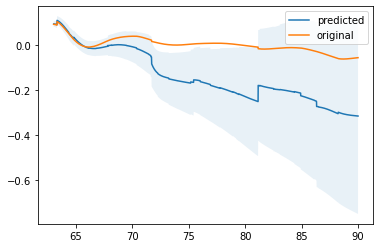

In [14]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF

rbf = ConstantKernel(1.0, (1e-1, 1e3) ) * RBF(10, (1e-3, 1e3))

gpr = GaussianProcessRegressor(kernel=rbf, alpha=0.1, normalize_y=True) 

gpr.fit(X_train, y_train) 
params = gpr.kernel_.get_params() 
mu_s, cov_s = gpr.predict(X_test, return_cov=True) 

mu_s = mu_s.ravel()
std = 1.96 * np.sqrt(np.diag(cov_s)) 

plt.plot(X_test['time_step_H'], mu_s) 
plt.plot(X_test['time_step_H'], y_test)
plt.fill_between(X_test['time_step_H'], mu_s + std, mu_s - std, alpha = 0.1)
plt.legend(["predicted", "original"])  

## Error_2

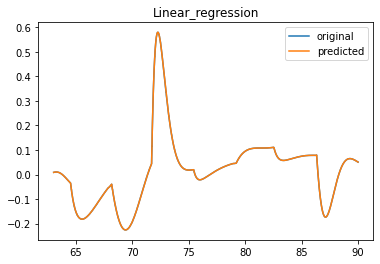

In [19]:
ss = StandardScaler()
lr = LinearRegression()
rfr = RandomForestRegressor(max_depth = 5, n_estimators=100,random_state = 0 )
etr = ExtraTreesRegressor(max_depth = 5, n_estimators = 100, random_state = 0)
gbr = GradientBoostingRegressor(random_state = 0) 

X_train = df_error_2.iloc[:6302, :16]
y_train = df_error_2.iloc[:6302, 16]
X_test = df_error_2.iloc[6302:, :16] 
y_test = df_error_2.iloc[6302:, 16:]

def compare(z1, title): 
    plt.plot(X_test['time_step_H'], y_test['error_2'])
    plt.plot(X_test['time_step_H'], z1)
    plt.legend(['original', 'predicted'])
    plt.title(title) 

lr.fit(X_train, y_train)
z1 = lr.predict(X_test) 
compare(z1, "Linear_regression")


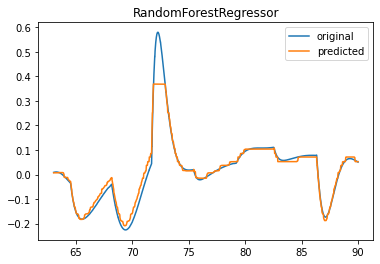

In [20]:
rfr.fit(X_train, y_train)
z1 = rfr.predict(X_test) 
compare(z1, "RandomForestRegressor") 

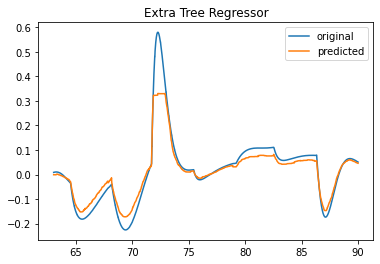

In [21]:
etr.fit(X_train, y_train)
z1 = etr.predict(X_test)  
compare(z1, "Extra Tree Regressor") 

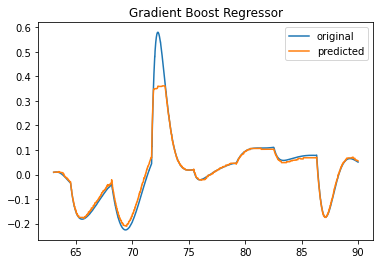

In [22]:
gbr.fit(X_train, y_train) 
z1 = gbr.predict(X_test) 
compare(z1, "Gradient Boost Regressor") 

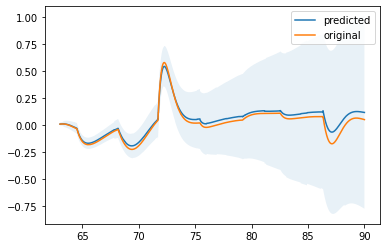

In [23]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF

rbf = ConstantKernel(1.0, (1e-1, 1e3) ) * RBF(10, (1e-3, 1e3))

gpr = GaussianProcessRegressor(kernel=rbf, alpha=0.1, normalize_y=True) 

gpr.fit(X_train, y_train) 
params = gpr.kernel_.get_params() 
mu_s, cov_s = gpr.predict(X_test, return_cov=True) 

mu_s = mu_s.ravel()
std = 1.96 * np.sqrt(np.diag(cov_s)) 

plt.plot(X_test['time_step_H'], mu_s) 
plt.plot(X_test['time_step_H'], y_test)
plt.fill_between(X_test['time_step_H'], mu_s + std, mu_s - std, alpha = 0.1)
plt.legend(["predicted", "original"])   

## Standard scale the Inputs

### Error 1

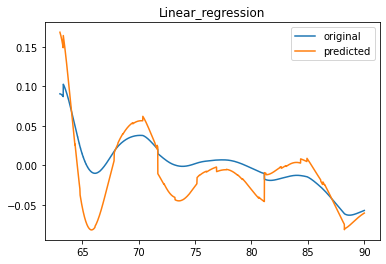

In [14]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt  
import random 
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
lr = LinearRegression()
rfr = RandomForestRegressor(max_depth = 5, n_estimators=100,random_state = 0 )
etr = ExtraTreesRegressor(max_depth = 5, n_estimators = 100, random_state = 0)
gbr = GradientBoostingRegressor(random_state = 0)

df = pd.read_csv('haptic_sim_1.csv') 


df_error_1 = df.iloc[:, :17]  
df_error_2 = df.iloc[:, :16] 
df_error_2['error_2'] = df['error_2'] 

X_train = df_error_1.iloc[:6302, :16]
y_train = df_error_1.iloc[:6302, 16:]
X_test = df_error_1.iloc[6302:, :16]
y_test = df_error_1.iloc[6302:, 16:]

def compare(z1, title): 
    plt.plot(X_test['time_step_H'], y_test['error_1'])
    plt.plot(X_test['time_step_H'], z1)
    plt.legend(['original', 'predicted'])
    plt.title(title) 

lr.fit(ss.fit_transform(X_train), y_train) 
z1 = lr.predict(ss.fit_transform(X_test)) 
compare(z1, "Linear_regression") 

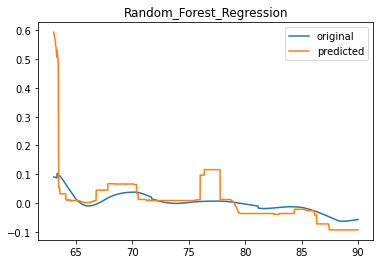

In [17]:
rfr.fit(ss.fit_transform(X_train), y_train)
z1 = rfr.predict(ss.fit_transform(X_test)) 
compare(z1, "Random_Forest_Regression") 

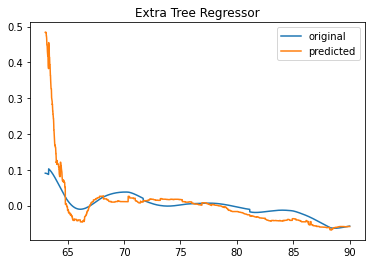

In [19]:
etr.fit(ss.fit_transform(X_train), y_train)
z1 = etr.predict(ss.fit_transform(X_test)) 
compare(z1, "Extra Tree Regressor") 

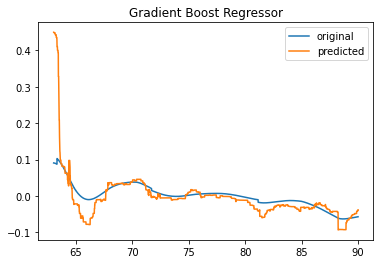

In [22]:
gbr.fit(ss.fit_transform(X_train), y_train)
z1 = gbr.predict(ss.fit_transform(X_test)) 
compare(z1, "Gradient Boost Regressor")

Text(0.5, 1.0, 'GP_error1_input_is_standard_scaled')

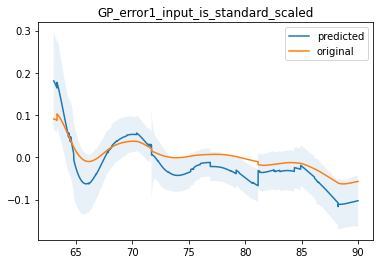

In [24]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF

rbf = ConstantKernel(1.0, (1e-1, 1e3) ) * RBF(10, (1e-3, 1e3))

gpr = GaussianProcessRegressor(kernel=rbf, alpha=0.1, normalize_y=True) 

gpr.fit(ss.fit_transform(X_train), y_train) 
params = gpr.kernel_.get_params() 
mu_s, cov_s = gpr.predict(ss.fit_transform(X_test), return_cov=True) 

mu_s = mu_s.ravel()
std = 1.96 * np.sqrt(np.diag(cov_s)) 

plt.plot(X_test['time_step_H'], mu_s) 
plt.plot(X_test['time_step_H'], y_test)
plt.fill_between(X_test['time_step_H'], mu_s + std, mu_s - std, alpha = 0.1)
plt.legend(["predicted", "original"])  
plt.title('GP_error1_input_is_standard_scaled')

### Error 2

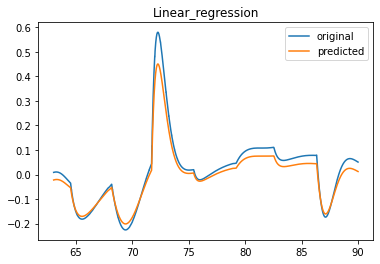

In [26]:
ss = StandardScaler()
lr = LinearRegression()
rfr = RandomForestRegressor(max_depth = 5, n_estimators=100,random_state = 0 )
etr = ExtraTreesRegressor(max_depth = 5, n_estimators = 100, random_state = 0)
gbr = GradientBoostingRegressor(random_state = 0)

df = pd.read_csv('haptic_sim_1.csv') 

df_error_1 = df.iloc[:, :17]  
df_error_2 = df.iloc[:, :16] 
df_error_2['error_2'] = df['error_2'] 

X_train = df_error_2.iloc[:6302, :16]
y_train = df_error_2.iloc[:6302, 16:]
X_test = df_error_2.iloc[6302:, :16]
y_test = df_error_2.iloc[6302:, 16:]

def compare(z1, title): 
    plt.plot(X_test['time_step_H'], y_test['error_2'])
    plt.plot(X_test['time_step_H'], z1)
    plt.legend(['original', 'predicted'])
    plt.title(title) 

lr.fit(ss.fit_transform(X_train), y_train) 
z1 = lr.predict(ss.fit_transform(X_test)) 
compare(z1, "Linear_regression") 

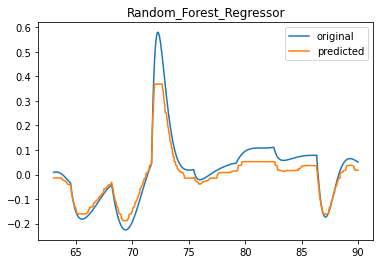

In [27]:
rfr.fit(ss.fit_transform(X_train), y_train) 
z1 = rfr.predict(ss.fit_transform(X_test)) 
compare(z1, "Random_Forest_Regressor") 

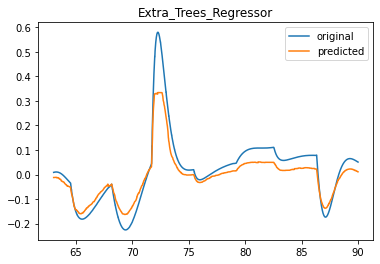

In [28]:
etr.fit(ss.fit_transform(X_train), y_train) 
z1 = etr.predict(ss.fit_transform(X_test)) 
compare(z1, "Extra_Trees_Regressor") 

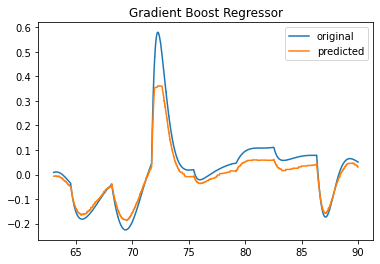

In [29]:
gbr.fit(ss.fit_transform(X_train), y_train)
z1 = gbr.predict(ss.fit_transform(X_test)) 
compare(z1, "Gradient Boost Regressor") 

Text(0.5, 1.0, 'GP_error2_input_is_standard_scaled')

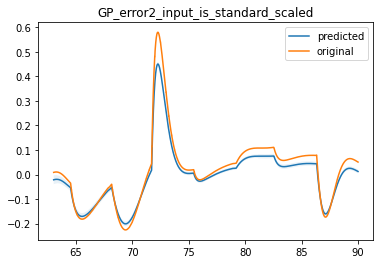

In [30]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF

rbf = ConstantKernel(1.0, (1e-1, 1e3) ) * RBF(10, (1e-3, 1e3))

gpr = GaussianProcessRegressor(kernel=rbf, alpha=0.1, normalize_y=True) 

gpr.fit(ss.fit_transform(X_train), y_train) 
params = gpr.kernel_.get_params() 
mu_s, cov_s = gpr.predict(ss.fit_transform(X_test), return_cov=True) 

mu_s = mu_s.ravel()
std = 1.96 * np.sqrt(np.diag(cov_s)) 

plt.plot(X_test['time_step_H'], mu_s) 
plt.plot(X_test['time_step_H'], y_test)
plt.fill_between(X_test['time_step_H'], mu_s + std, mu_s - std, alpha = 0.1)
plt.legend(["predicted", "original"])  
plt.title('GP_error2_input_is_standard_scaled')

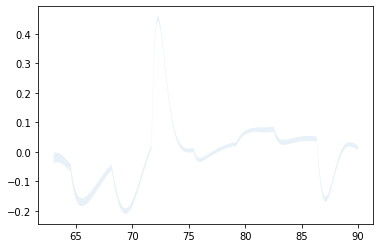

In [31]:
plt.fill_between(X_test['time_step_H'], mu_s + std, mu_s - std, alpha = 0.1) 

# Added new "neg" attribute. when neg = True give same input for "Theta_h" and "Theta_a"

Text(0.5, 1.0, 'Theta_SW_disp_vel_acc')

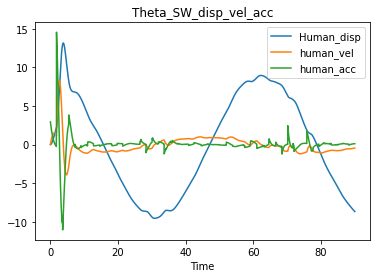

In [6]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from sympy import * 
#from spring_damp import force_time, mass_damp_spring, ideal_actual, graphs
from haptic import haptic_class
import random
import yaml 
random.seed(49) 

with open('Human_Auto.yaml') as File:
    d = yaml.load(File, Loader=yaml.FullLoader)
#can't give negative sin as input to function
hap = haptic_class(dic = d, Theta_h = cos, Theta_a= cos) 

plt.plot(hap.Theta['H_time'], hap._vector[:,0] ) 
plt.plot(hap.Theta['H_time'], hap._vector[:,1] )
plt.plot(hap.Theta['H_time'], hap.acc_sw) 
plt.xlabel('Time')
plt.legend(['Human_disp', 'human_vel', 'human_acc']) 
plt.title('Theta_SW_disp_vel_acc') 

Text(0.5, 1.0, 'Theta_S_disp_vel_acc')

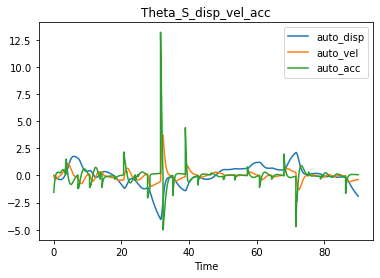

In [7]:
plt.plot(hap.Theta['A_time'],hap._vector[:,2] ) 
plt.plot(hap.Theta['A_time'],hap._vector[:,3] )
plt.plot(hap.Theta['H_time'], hap.acc_s) 
plt.xlabel('Time')
plt.legend(['auto_disp', 'auto_vel', 'auto_acc']) 
plt.title('Theta_S_disp_vel_acc') 

Text(0.5, 1.0, 'ERROR')

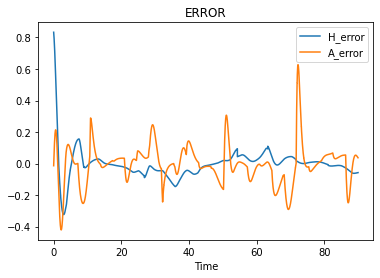

In [3]:
plt.plot(hap.Theta['H_time'],hap.error[:, 0] ) 
plt.plot(hap.Theta['A_time'],hap.error[:, 1] )
#plt.plot(hap.Theta['H_time'], hap.acc_a) 
plt.xlabel('Time')
plt.legend(['H_error', 'A_error']) 
plt.title('ERROR')

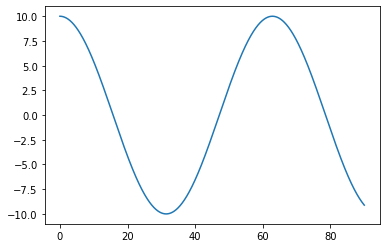

In [4]:
z = hap.Theta 
plt.plot(z["H_time"],z['H']) 

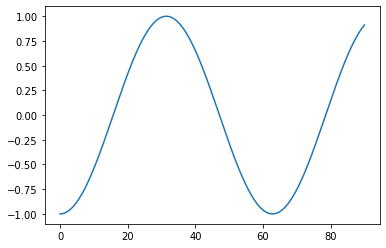

In [5]:
plt.plot(z["A_time"],z['A']) 

# 10 SIMS WITH ACTUAL THETA_H == THETA_A

In [ ]:
import numpy as np
from scipy.integrate import odeint
import math
import matplotlib.pyplot as plt
from sympy import * 
#from spring_damp import force_time, mass_damp_spring, ideal_actual, graphs
from haptic import haptic_actual
import random
import yaml
random.seed(49) 

with open('Human_Auto.yaml') as File:
    d = yaml.load(File, Loader=yaml.FullLoader)
z = haptic_actual(d)
D = z.data_list